In [61]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
from utide._ut_constants import ut_constants as utide
import os
from utils import *
import pandas as pd
import cartopy.feature as cfeature
import xesmf as xe
from scipy.ndimage import gaussian_filter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from palette import *
import statsmodels.api as sm


# useful variables
j=np.complex(0,1)
cpd=2.*np.pi/86400. # from cpd to radian/s
crs = ccrs.PlateCarree() # cartopy


#datadir = './'
datadir = '/home7/pharos/othr/cgonzale/data/iwsst_mit/1month/'
datadir_out = '/home7/pharos/othr/cgonzale/data/iwsst_mit/working/'
graphdir = '/home3/homedir7/perso/cgonzale/IWAVE/figures/Simul_MITgcm/'
bathy = '/home2/pharos/othr/aponte/bathy/ETOPO2v2c_f4.nc'
datadir_tides = '/home2/pharos/othr/aponte/tides/HRET/'
datadir_tides2 = '/home2/pharos/othr/aponte/tides/FES2014/'
# tmp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

palette = '/home3/homedir7/perso/cgonzale/IWAVE/script/palette/medspiration.rgb'
csst = getColorMap( rgbFile = palette )

Frame = 'False' #to plot frame Velocity

In [2]:
matplotlib.rcParams.update({'font.size': 14})

In [3]:
Region = 'AustraliaHW'
if(Region == 'AustraliaHW'):
    fregion = 'nwa_'
elif (Region == 'Mozamb2'):
    fregion = 'mad_'

In [4]:
file = fregion+'SSU.nc'
dsU = xr.open_dataset(datadir+file,chunks={'j':100})
file = fregion+'SSV.nc'
dsV = xr.open_dataset(datadir+file,chunks={'j':100})

In [5]:
print(dsU)

<xarray.Dataset>
Dimensions:  (i: 2000, j: 2000, time: 625)
Coordinates:
  * i        (i) int64 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 ...
  * j        (j) int64 1500 1501 1502 1503 1504 1505 1506 1507 1508 1509 ...
    face     int64 ...
    XC       (j, i) float32 dask.array<shape=(2000, 2000), chunksize=(100, 2000)>
    YC       (j, i) float32 dask.array<shape=(2000, 2000), chunksize=(100, 2000)>
    rA       (j, i) float32 dask.array<shape=(2000, 2000), chunksize=(100, 2000)>
    Depth    (j, i) float32 dask.array<shape=(2000, 2000), chunksize=(100, 2000)>
  * time     (time) float64 1.313e+07 1.314e+07 1.314e+07 1.314e+07 ...
    iters    (time) int64 dask.array<shape=(625,), chunksize=(625,)>
Data variables:
    SSU      (time, j, i) float32 dask.array<shape=(625, 2000, 2000), chunksize=(625, 100, 2000)>


### Select for vivo period (same than for SST harmonic analysis )

In [6]:
day2second = 3600*24
t0 = 1.35e7+(3600*36)+day2second
tf= t0+2*day2second

In [7]:
if (Region == 'AustraliaHW'):
    latmin_z = -22 #-14,-13
    latmax_z = -13#-12, -7
    lonmin_z =  114#52,49
    lonmax_z =  124#55,53
    vmin = 22
    vmax = 29
    vmax_grad = 0.1
    vmax_tw=0.05
    it=1
   

U2d_t = dsU['SSU'].where(dsU['SSU']['XC']>=lonmin_z, drop=True)
U2d_t = U2d_t.where(U2d_t['XC']<=lonmax_z, drop=True)
U2d_t = U2d_t.where(U2d_t['YC']<=latmax_z, drop=True)
U2d_t = U2d_t.where(U2d_t['YC']>=latmin_z, drop=True)

In [8]:
V2d_t = dsV['SSV'].where(dsV['SSV']['XC']>=lonmin_z, drop=True)
V2d_t = V2d_t.where(V2d_t['XC']<=lonmax_z, drop=True)
V2d_t = V2d_t.where(V2d_t['YC']<=latmax_z, drop=True)
V2d_t = V2d_t.where(V2d_t['YC']>=latmin_z, drop=True)

In [9]:
#select in time
U2d_2days=U2d_t.sel(time=slice(t0,tf))
print(U2d_2days)
V2d_2days=V2d_t.sel(time=slice(t0,tf))
print(V2d_2days)

<xarray.DataArray (time: 49, j: 492, i: 480)>
dask.array<shape=(49, 492, 480), dtype=float32, chunksize=(49, 73, 480)>
Coordinates:
  * i        (i) int64 2976 2977 2978 2979 2980 2981 2982 2983 2984 2985 ...
  * j        (j) int64 2427 2428 2429 2430 2431 2432 2433 2434 2435 2436 ...
    face     int64 4
    XC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    YC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    rA       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    Depth    (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
  * time     (time) float64 1.372e+07 1.372e+07 1.372e+07 1.373e+07 ...
    iters    (time) int64 dask.array<shape=(49,), chunksize=(49,)>
<xarray.DataArray (time: 49, j: 492, i: 480)>
dask.array<shape=(49, 492, 480), dtype=float32, chunksize=(49, 73, 480)>
Coordinates:
  * i        (i) int64 2976 2977 2978 2979 2980 2981 2982 2983 2984 2985 ...
  * j        (j) int64 2427 2428 

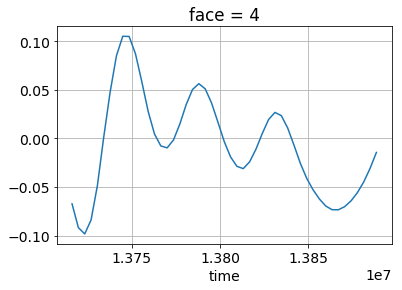

In [10]:
Umean_xy_2days =U2d_2days.mean(dim=['i','j'])
Umean_xy_2days.plot()
plt.grid()

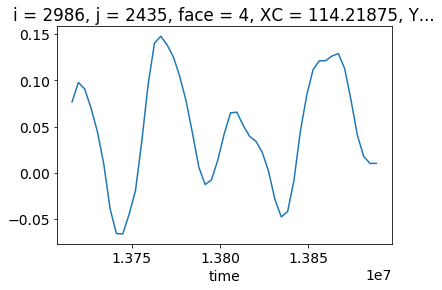

In [18]:
## select one pixel
U_t=U2d_2days.sel(i=2986,j=2435)
U_t.plot()


In [19]:
print(U_t.values)

[ 0.0766265   0.09770291  0.09062763  0.06980546  0.04456064  0.00973896
 -0.03867939 -0.06557778 -0.06594665 -0.04480512 -0.0193737   0.03413827
  0.09564859  0.14017358  0.14765108  0.13819882  0.12501107  0.10388396
  0.07732188  0.04262368  0.00606703 -0.01262664 -0.00743775  0.01417935
  0.04222926  0.06490903  0.06557176  0.05121544  0.03954001  0.03416255
  0.02214654  0.00149839 -0.02884337 -0.04758257 -0.04176023 -0.00796134
  0.04466286  0.08339628  0.11138757  0.1211371   0.1212132   0.1263163
  0.12887338  0.11259035  0.07848271  0.04067033  0.01769133  0.01018736
  0.01030458]


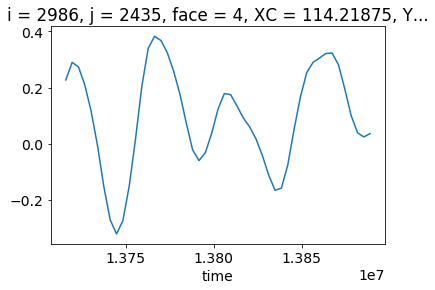

In [20]:
V_t=V2d_2days.sel(i=2986,j=2435)
V_t.plot()

In [23]:
t=U_t.time
print(t)

<xarray.DataArray 'time' (time: 49)>
array([13716000., 13719600., 13723200., 13726800., 13730400., 13734000.,
       13737600., 13741200., 13744800., 13748400., 13752000., 13755600.,
       13759200., 13762800., 13766400., 13770000., 13773600., 13777200.,
       13780800., 13784400., 13788000., 13791600., 13795200., 13798800.,
       13802400., 13806000., 13809600., 13813200., 13816800., 13820400.,
       13824000., 13827600., 13831200., 13834800., 13838400., 13842000.,
       13845600., 13849200., 13852800., 13856400., 13860000., 13863600.,
       13867200., 13870800., 13874400., 13878000., 13881600., 13885200.,
       13888800.])
Coordinates:
    i        int64 2986
    j        int64 2435
    face     int64 4
    XC       float32 dask.array<shape=(), chunksize=()>
    YC       float32 dask.array<shape=(), chunksize=()>
    rA       float32 dask.array<shape=(), chunksize=()>
    Depth    float32 dask.array<shape=(), chunksize=()>
  * time     (time) float64 1.372e+07 1.372e+07 1.372e

---

### Create frame velocity components

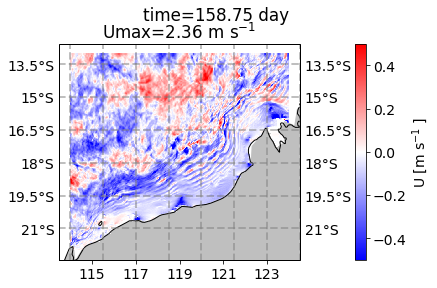

In [58]:
fig = plt.figure()
#plot wave SST
t0=0

pad = 0.15
ax = make_cartopy(1,1,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
#cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cs = ax.pcolormesh(U2d_2days.XC,U2d_2days.YC,U2d_2days[t0,:,:], \
                transform = ccrs.PlateCarree(),cmap='bwr',vmin=-0.5,vmax=0.5)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#cbar.set_label(cst+  r'  $T_w[^\circ$C]')
cbar.set_label(r'U [m s$^{-1}$ ]')
ax.set_title(r'Umax=%.2f m s$^{-1}$' %(np.abs(U2d_2days[t0,:,:]).max(skipna=True) ))
thour=(U2d_2days.time[t0]/3600)
tday=(U2d_2days.time[t0]/(3600*24.))
title=str(tday.values)
fig.suptitle('time=%.2f day'%(tday.values))
plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)
figname='U_'+str(int(thour.values))+'.png'
frame = graphdir+'movies/U/'+figname
fig.savefig(frame, dpi=150)

In [15]:
if(Frame):
    Nt=U2d_2days.time.size
    for t0 in range(Nt):
        fig = plt.figure()
        #plot wave SST


        pad = 0.15
        ax = make_cartopy(1,1,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
        #cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
        cs = ax.pcolormesh(U2d_2days.XC,U2d_2days.YC,U2d_2days[t0,:,:], \
                        transform = ccrs.PlateCarree(),cmap='bwr',vmin=-0.5,vmax=0.5)
        cbar = fig.colorbar(cs, ax=ax, pad=pad)
        #cbar.set_label(cst+  r'  $T_w[^\circ$C]')
        cbar.set_label(r'U [m s$^{-1}$ ]')
        ax.set_title(r'Umax=%.2f m s$^{-1}$' %(np.abs(U2d_2days[t0,:,:]).max(skipna=True) ))
        thour=(U2d_2days.time[t0]/3600)
        tday=(U2d_2days.time[t0]/(3600*24.))
        title=str(tday.values)
        fig.suptitle('time=%.2f day'%(tday.values))
        plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)
        figname='U_'+str(int(thour.values))+'.png'
        frame = graphdir+'movies/U/'+figname
        fig.savefig(frame, dpi=150)
        plt.close(fig)

In [59]:
if(Frame):
    Nt=V2d_2days.time.size
    for t0 in range(Nt):
        fig = plt.figure()
        #plot wave SST


        pad = 0.15
        ax = make_cartopy(1,1,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
        #cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
        cs = ax.pcolormesh(V2d_2days.XC,V2d_2days.YC,V2d_2days[t0,:,:], \
                        transform = ccrs.PlateCarree(),cmap='bwr',vmax=-0.5,vmin=0.5)
        cbar = fig.colorbar(cs, ax=ax, pad=pad)
        #cbar.set_label(cst+  r'  $T_w[^\circ$C]')
        cbar.set_label(r'V [m s$^{-1}$ ]')
        ax.set_title(r'Vmax=%.2f m s$^{-1}$' %(np.abs(V2d_2days[t0,:,:]).max(skipna=True) ))
        thour=(V2d_2days.time[t0]/3600)
        tday=(V2d_2days.time[t0]/(3600*24.))
        title=str(tday.values)
        fig.suptitle('time=%.2f day'%(tday.values))
        plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)
        figname='V_'+str(int(thour.values))+'.png'
        frame = graphdir+'movies/V/'+figname
        fig.savefig(frame, dpi=150)
        plt.close(fig)

In [60]:
dt = t[1]-t[0]
print(dt.values)

3600.0


In [25]:
omega_M2 = 1.923*cpd# rad/s

In [26]:
U_t_mean = U_t.mean()
V_t_mean = V_t.mean()
print(U_t_mean.values,V_t_mean.values)

0.04615411 0.09446138


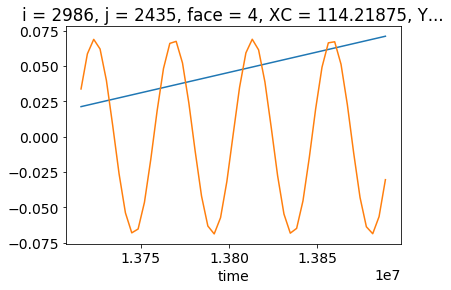

In [28]:
uslow, ufast = get_slow_fast(U_t, omega = omega_M2)
#Xty_func=get_slow_fast(sst_t)
#print(Xty_func)
#print(vslow)
uslow.plot()
ufast.plot()

In [30]:
U_recons = uslow+ufast

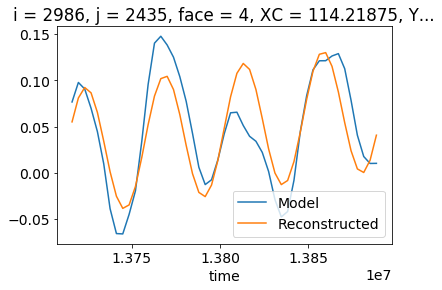

In [31]:
U_t.plot(label='Model')
U_recons.plot(label = 'Reconstructed')
plt.legend(loc=4)

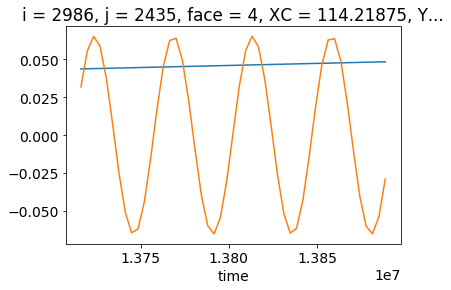

In [32]:
uslow, ufast = get_slow_fast(U_t, omega = omega_M2, omega2 = omega_M2/2.)
#Xty_func=get_slow_fast(sst_t)
#print(Xty_func)
#print(vslow)
uslow.plot()
ufast.plot()

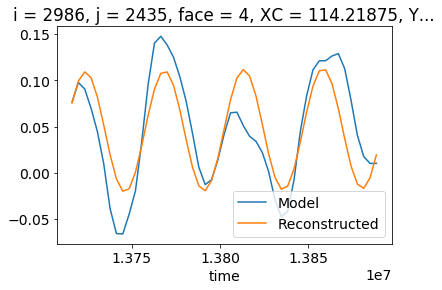

In [34]:
U_recons = uslow+ufast
U_t.plot(label='Model')
U_recons.plot(label='Reconstructed')
plt.legend(loc=4)

# Decompose semidiurnal component

In [35]:
%time Uslow_semi, Ufast_semi = get_slow_fast(U2d_2days)

CPU times: user 416 ms, sys: 228 ms, total: 644 ms
Wall time: 405 ms


In [36]:
print(Uslow_semi)

<xarray.DataArray (j: 492, i: 480, time: 49)>
dask.array<shape=(492, 480, 49), dtype=float64, chunksize=(73, 480, 49)>
Coordinates:
    face     int64 4
  * i        (i) int64 2976 2977 2978 2979 2980 2981 2982 2983 2984 2985 ...
  * j        (j) int64 2427 2428 2429 2430 2431 2432 2433 2434 2435 2436 ...
    XC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    YC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    rA       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    Depth    (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
  * time     (time) float64 1.372e+07 1.372e+07 1.372e+07 1.373e+07 ...
    iters    (time) int64 dask.array<shape=(49,), chunksize=(49,)>


In [37]:
Uslow_semi = Uslow_semi.chunk(chunks = {'j': 492,'i':480,'time':49})

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 27.5 s, sys: 44 s, total: 1min 11s
Wall time: 11min 44s


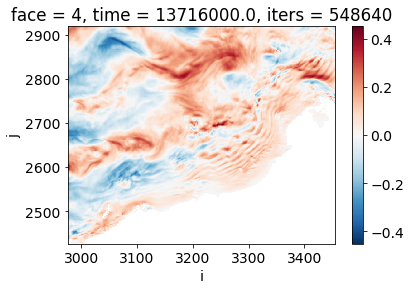

In [36]:
#%time Uslow_semi.isel(time=0).plot()

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 27.1 s, sys: 46.5 s, total: 1min 13s
Wall time: 19min 8s


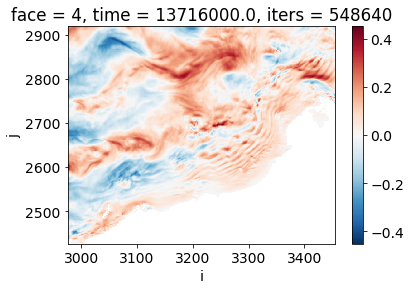

In [32]:
#%time Uslow_semi.isel(time=0).plot()

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


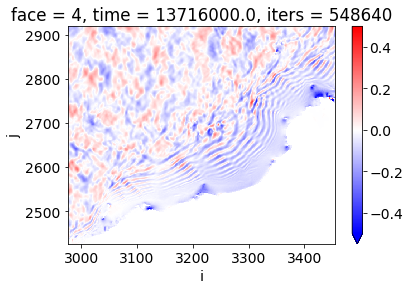

In [31]:
#vfast_semi.isel(time=0).plot(vmin = -0.5, vmax = 0.5, cmap = 'bwr')

In [38]:
%time Vslow_semi, Vfast_semi = get_slow_fast(V2d_2days)

CPU times: user 417 ms, sys: 227 ms, total: 645 ms
Wall time: 420 ms


In [39]:
Vslow_semi.name = 'V_slow_semi'
Vfast_semi.name = 'V_fast_semi'

In [40]:
Uslow_semi.name = 'U_slow_semi'
Ufast_semi.name = 'U_fast_semi'

In [41]:

file_out = datadir_out+'fast_U_semidiurnal.nc'
if os.path.exists(file_out):
    os.remove(file_out)

##ds.isel(time=slice(0,24), face=1).to_netcdf(file_out, mode='w', unlimited_dims='time') # not working, weird incompatible chunk error
Ufast_semi.isel(time=slice(0,49)).to_netcdf(file_out, mode='w')

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [46]:
file_out = datadir_out+'slow_U_semidiurnal.nc'

if os.path.exists(file_out):
    os.remove(file_out)
##ds.isel(time=slice(0,24), face=1).to_netcdf(file_out, mode='w', unlimited_dims='time') # not working, weird incompatible chunk error
%time Uslow_semi.isel(time=slice(0,49)).to_netcdf(file_out, mode='w')

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 14.1 s, sys: 22.1 s, total: 36.2 s
Wall time: 5min 53s


In [47]:
file_out = datadir_out+'fast_V_semidiurnal.nc'
if os.path.exists(file_out):
    os.remove(file_out)

##ds.isel(time=slice(0,24), face=1).to_netcdf(file_out, mode='w', unlimited_dims='time') # not working, weird incompatible chunk error
Vfast_semi.isel(time=slice(0,49)).to_netcdf(file_out, mode='w')

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [48]:
file_out = datadir_out+'slow_V_semidiurnal.nc'

if os.path.exists(file_out):
    os.remove(file_out)
##ds.isel(time=slice(0,24), face=1).to_netcdf(file_out, mode='w', unlimited_dims='time') # not working, weird incompatible chunk error
Vslow_semi.isel(time=slice(0,49)).to_netcdf(file_out, mode='w')

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


---

## Compute skill

In [62]:
U_recons_semi= Uslow_semi+Ufast_semi
skill_U_semi = skill(U2d_2days, U_recons_semi)

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/reductions.py:297: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


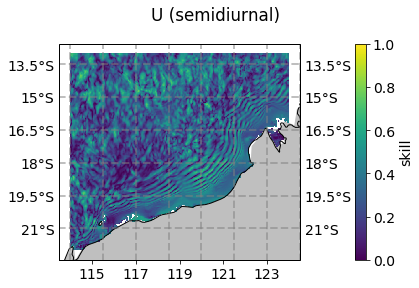

In [63]:
fig = plt.figure()
#plot wave SST
pad = 0.15
ax = make_cartopy(1,1,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
#cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cs = ax.pcolormesh(Uslow_semi.XC,Uslow_semi.YC,skill_U_semi, \
                transform = ccrs.PlateCarree(),vmin=0,vmax=1)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#cbar.set_label(cst+  r'  $T_w[^\circ$C]')
fig.suptitle('U (semidiurnal)')
cbar.set_label(r'skill')
plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)
figname='U_Skill.png'
frame = graphdir+'movies/Semidiurnal_U/'+figname
fig.savefig(frame, dpi=150)

In [47]:
V_recons_semi= Vslow_semi+Vfast_semi
skill_V_semi = skill(V2d_2days, V_recons_semi)

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/reductions.py:297: RuntimeWarning: invalid value encountered in true_divide
  u = total / n
/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


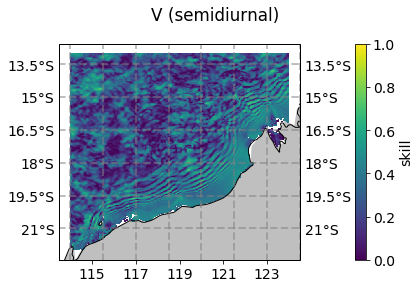

In [64]:
fig = plt.figure()
#plot wave SST
pad = 0.15
ax = make_cartopy(1,1,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
#cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cs = ax.pcolormesh(Vslow_semi.XC,Vslow_semi.YC,skill_V_semi, \
                transform = ccrs.PlateCarree(),vmin=0,vmax=1)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#cbar.set_label(cst+  r'  $T_w[^\circ$C]')
fig.suptitle('V (semidiurnal)')
cbar.set_label(r'skill')
plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)
figname='V_Skill.png'
frame = graphdir+'movies/Semidiurnal_V/'+figname
fig.savefig(frame, dpi=150)

---

### Compute residuals

In [49]:
Uresidual = U2d_2days - U_recons_semi
Vresidual = V2d_2days - V_recons_semi

In [51]:
print(Uresidual)

<xarray.DataArray (time: 49, j: 492, i: 480)>
dask.array<shape=(49, 492, 480), dtype=float64, chunksize=(49, 73, 480)>
Coordinates:
  * i        (i) int64 2976 2977 2978 2979 2980 2981 2982 2983 2984 2985 ...
  * j        (j) int64 2427 2428 2429 2430 2431 2432 2433 2434 2435 2436 ...
    face     int64 4
    XC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    YC       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    rA       (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
    Depth    (j, i) float32 dask.array<shape=(492, 480), chunksize=(73, 480)>
  * time     (time) float64 1.372e+07 1.372e+07 1.372e+07 1.373e+07 ...
    iters    (time) int64 dask.array<shape=(49,), chunksize=(49,)>


/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


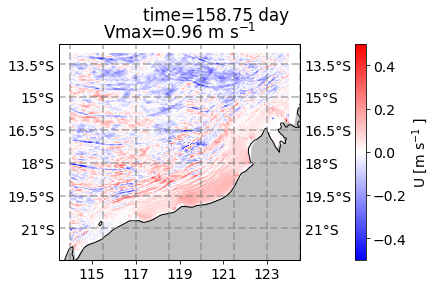

In [53]:
fig = plt.figure()
#plot wave SST

t0=0
pad = 0.15
ax = make_cartopy(1,1,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
#cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
cs = ax.pcolormesh(Vresidual.XC,Vresidual.YC,Vresidual[t0,:,:], \
                transform = ccrs.PlateCarree(),cmap='bwr',vmax=-0.5,vmin=0.5)
cbar = fig.colorbar(cs, ax=ax, pad=pad)
#cbar.set_label(cst+  r'  $T_w[^\circ$C]')
cbar.set_label(r'U [m s$^{-1}$ ]')
ax.set_title(r'Vmax=%.2f m s$^{-1}$' %(np.abs(Vresidual[t0,:,:]).max(skipna=True) ))
thour=(V2d_2days.time[t0]/3600)
tday=(V2d_2days.time[t0]/(3600*24.))
title=str(tday.values)
fig.suptitle('time=%.2f day'%(tday.values))
plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)
figname='V_residual_'+str(int(thour.values))+'.png'
frame = graphdir+'movies/Vresidual/'+figname
fig.savefig(frame, dpi=150)


In [55]:
Frame = True
if(Frame):
    Nt=Uresidual.time.size
    for t0 in range(Nt):
        fig = plt.figure()
        pad = 0.15
        ax = make_cartopy(1,1,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
        #cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
        cs = ax.pcolormesh(Vresidual.XC,Vresidual.YC,Vresidual[t0,:,:], \
                        transform = ccrs.PlateCarree(),cmap='bwr',vmax=-0.5,vmin=0.5)
        cbar = fig.colorbar(cs, ax=ax, pad=pad)
        #cbar.set_label(cst+  r'  $T_w[^\circ$C]')
        cbar.set_label(r'V [m s$^{-1}$ ]')
        ax.set_title(r'Vmax=%.2f m s$^{-1}$' %(np.abs(Vresidual[t0,:,:]).max(skipna=True) ))
        thour=(V2d_2days.time[t0]/3600)
        tday=(V2d_2days.time[t0]/(3600*24.))
        title=str(tday.values)
        fig.suptitle('time=%.2f day'%(tday.values))
        plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)
        figname='V_residual_'+str(int(thour.values))+'.png'
        frame = graphdir+'movies/Vresidual/'+figname
        fig.savefig(frame, dpi=150)

        plt.close(fig)

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [56]:
if(Frame):
    Nt=Uresidual.time.size
    for t0 in range(Nt):
        fig = plt.figure()
        pad = 0.15
        ax = make_cartopy(1,1,projection=ccrs.PlateCarree(), fig=fig, resolution='50m',nfig=1, lonticks = [115,117,119,121,123])
        #cs = ax.imshow(toplt, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(),vmax=vmax_tw)
        cs = ax.pcolormesh(Uresidual.XC,Uresidual.YC,Uresidual[t0,:,:], \
                        transform = ccrs.PlateCarree(),cmap='bwr',vmax=-0.5,vmin=0.5)
        cbar = fig.colorbar(cs, ax=ax, pad=pad)
        #cbar.set_label(cst+  r'  $T_w[^\circ$C]')
        cbar.set_label(r'U [m s$^{-1}$ ]')
        ax.set_title(r'Vmax=%.2f m s$^{-1}$' %(np.abs(Uresidual[t0,:,:]).max(skipna=True) ))
        thour=(U2d_2days.time[t0]/3600)
        tday=(U2d_2days.time[t0]/(3600*24.))
        title=str(tday.values)
        fig.suptitle('time=%.2f day'%(tday.values))
        plt.subplots_adjust(left=0.1,right=0.95,hspace=0.5,wspace=0.3,top=0.85,bottom=0.1)
        figname='U_residual_'+str(int(thour.values))+'.png'
        frame = graphdir+'movies/Uresidual/'+figname
        fig.savefig(frame, dpi=150)

        plt.close(fig)

/home/lervily/cgonzale/miniconda3/envs/iwsst/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
